# Lab D (solved)

### Installing necessary packages

Before we begin, you will need to install some prerequisites into your environment. Run the cell below to complete these installations. At the end, the cell outputs will be cleared.

In [3]:
%pip install uv 
!uv pip install 'iqm-client[qiskit]==29.14' 
%pip install lagrangeclient --index-url https://gitlab.linksfoundation.com/api/v4/projects/1709/packages/pypi/simple

%pip install qiskit-aer==0.16.1

%pip install matplotlib pylatexenc

from IPython.display import clear_output
clear_output()

In [4]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, Aer

import numpy as np

from iqm.qiskit_iqm import IQMProvider

In [5]:
%pip install uv --quiet
!uv pip install 'iqm-client[qiskit]==29.14' --quiet
%pip install lagrangeclient --index-url https://gitlab.linksfoundation.com/api/v4/projects/1709/packages/pypi/simple

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://gitlab.linksfoundation.com/api/v4/projects/1709/packages/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [6]:
!lagrangeclient

## On Windows
# import sys
# !{sys.executable} -m lagrangeclient

import json
with open('tokens.json', 'r') as f:
    config = json.load(f)
access_token = config['access_token']

== DEVICE LOGIN FLOW ==
🔗 Visit this URL in your browser:
https://spark.quantum.linksfoundation.com/auth/realms/cortex/device?user_code=ZJEZ-LZRQ
Waiting for user to complete login...
=========== TOKEN ===========
eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPN2g5cUtOOGRsdi1OZlo3Qm10NEJNZC0yaUFnMWt5STFEa2h0R3M5OU5rIn0.eyJleHAiOjE3NjQ3ODMyNjUsImlhdCI6MTc2NDE3ODQ2NSwiYXV0aF90aW1lIjoxNzY0MDY4OTU3LCJqdGkiOiJvbnJ0ZGc6MjdiZmQzNzktYmJjZi0xZDJmLTU2NmUtZDZmZDgyMDMxMjZjIiwiaXNzIjoiaHR0cHM6Ly9zcGFyay5xdWFudHVtLmxpbmtzZm91bmRhdGlvbi5jb20vYXV0aC9yZWFsbXMvY29ydGV4IiwiYXVkIjoiYWNjb3VudCIsInN1YiI6IjRjZmJkMGZmLWEwMzktNGZhYS05NDc2LWVjMjFkNTgzZGQ5NSIsInR5cCI6IkJlYXJlciIsImF6cCI6ImlxbV9jbGllbnQiLCJzaWQiOiI2NTY4N2E4OC1jZjA5LTQyNjMtOWExNC1kMzdmYmVjNmE4ZjEiLCJhY3IiOiIwIiwiYWxsb3dlZC1vcmlnaW5zIjpbImh0dHBzOi8vc3BhcmsucXVhbnR1bS5saW5rc2ZvdW5kYXRpb24uY29tLyoiLCJodHRwczovL2lxbXNwYXJrLnBvbGl0by5pdC8iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbImV4YV9hZG1pbiIsIm9mZmxpbmVfYWNjZXNzIiwicGxhdGZvcm0tYWRtaW4iLCJjb3J0ZXhfYW

## Quantum Fourier Transform

The quantum Fourier transform acts on a quantum state $\vert X\rangle = \sum_{j=0}^{N-1} a_j \vert j \rangle$ and maps it to the quantum state $\vert Y\rangle = \sum_{k=0}^{N-1} b_k \vert k \rangle$ according to the formula


$$b_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}a_j\omega_N^{jk}$$


where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$. Note that only the amplitudes of the state were affected by this transformation.

For a given state $\vert j \rangle$, this can also be expressed as the map:


$$\vert j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle$$



Or the unitary matrix:


$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert$$

Remember the quantum Fourier transform look like for a generic $N$. Again, $N=2^n$ and $QFT_N$ acts on the state $\vert x \rangle = \vert x_1\ldots x_n \rangle$ where $x_1$ is the most significant bit.
$$
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials}
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding}
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1}
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right)
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right)
\end{aligned}
$$


### The Circuit that Implements the QFT <a name="circuit"></a>

The circuit that implements QFT makes use of two gates. The first one is a single-qubit Hadamard gate, $H$, that you already know. You have already seen that the action of $H$ on the single-qubit state $\vert x_k\rangle$ is



$$H\vert x_k \rangle = \frac{1}{\sqrt{2}}\left(\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_k\right)\vert1\rangle\right)$$



The second is a two-qubit controlled rotation $CROT_k$ given in block-diagonal form as

$$CROT_k = \left[\begin{matrix}
I&0\\
0&UROT_k\\
\end{matrix}\right]$$

where

$$UROT_k = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]$$

The action of $CROT_k$ on a two-qubit state $\vert x_l x_j\rangle$ where the first qubit is the control and the second is the target is given by



$$CROT_k\vert 0x_j\rangle = \vert 0x_j\rangle$$


and


$$CROT_k\vert 1x_j\rangle = \exp\left( \frac{2\pi i}{2^k}x_j \right)\vert 1x_j\rangle$$


The resulting circuit operates as follows. We start with an n-qubit input state $\vert x_1x_2\ldots x_n\rangle$.

1) After the first Hadamard gate on qubit 1, the state is transformed from the input state to

$$
H_1\vert x_1x_2\ldots x_n\rangle =
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

2) After the $UROT_2$ gate on qubit 1 controlled by qubit 2, the state is transformed to

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

3) After the application of the last $UROT_n$ gate on qubit 1 controlled by qubit $n$, the state becomes

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x_n +
\frac{2\pi i}{2^{n-1}}x_{n-1} +
\ldots +
\frac{2\pi i}{2^2}x_2 +
\frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

Noting that

$$
x = 2^{n-1}x_1 + 2^{n-2}x_2 + \ldots + 2^1x_{n-1} + 2^0x_n
$$

we can write the above state as

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

4) After the application of a similar sequence of gates for qubits $2\ldots n$, we find the final state to be:

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{n-1}}x
\right)
\vert1\rangle\right]
\otimes
\ldots
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{2}}x
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{1}}x
\right)
\vert1\rangle\right]
$$

which is exactly the QFT of the input state as derived above with the caveat that the order of the qubits is reversed in the output state.
</ol>

### Qiskit Implementation<a id='implementation'></a>

In Qiskit, the implementation of the $CROT$ gate used in the discussion above is a controlled phase rotation gate. This gate is defined in [OpenQASM](https://github.com/QISKit/openqasm) as

$$
CP(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}
$$

Hence, the mapping from the $CROT_k$ gate in the discussion above into the $CP$ gate is found from the equation

$$
\theta = 2\pi/2^k = \pi/2^{k-1}
$$

### Exercise 1: build the QFT on 2 Qubits <a id="threeqft"></a>

**Note**: Qiskit's least significant bit has the lowest index (0), thus the circuit will be mirrored in relation to the image!

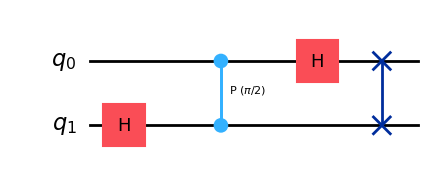

In [7]:
qft_example = QuantumCircuit(2)

##############################
# add gates to your circuit here

qft_example.h(1)
qft_example.cp(np.pi/2, 0, 1)
qft_example.h(0)
qft_example.swap(0, 1)

##############################

qft_example.draw(output='mpl')

### Exercise 2: build the QFT on 3 qubits

https://drive.google.com/file/d/1oN7ZdFCNRsHTzzYnNPiANykgbbjhRt5o/view?usp=sharing


It is useful to work out the relevant code for the 3-qubit case before generalizing to the $n$-qubit case. First, we must define our quantum circuit:


In [8]:
# Define the quantum circuit
qc = QuantumCircuit(3, 3)

**Note again**: Remember that Qiskit's least significant bit has the lowest index (0), thus the circuit will be mirrored in relation to the image.

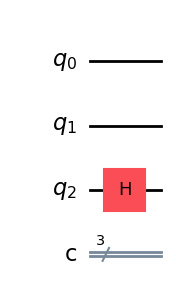

In [9]:
# Apply the first Hadamard on qubit 2
qc.h(2)
qc.draw('mpl')

Next, we want to turn this an extra quarter turn if qubit 1 is in the state $|1\rangle$:

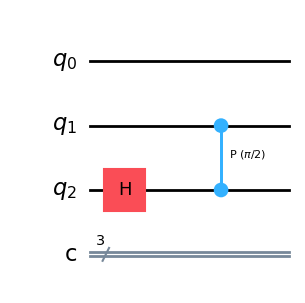

In [10]:
# CROT from qubit 1 to qubit 2
qc.cp(np.pi/2, 1, 2)
qc.draw('mpl')

And another eighth turn if the least significant qubit (0) is $|1\rangle$:

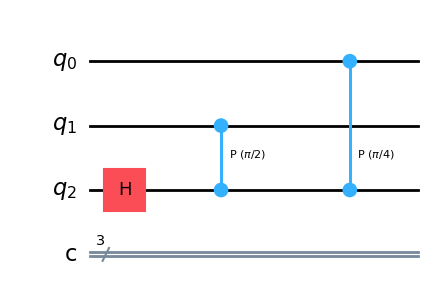

In [11]:
# CROT from qubit 2 to qubit 0
qc.cp(np.pi/4, 0, 2)
qc.draw('mpl')

With that qubit taken care of, we can now ignore it and repeat the process, using the same logic for qubits 0 and 1:

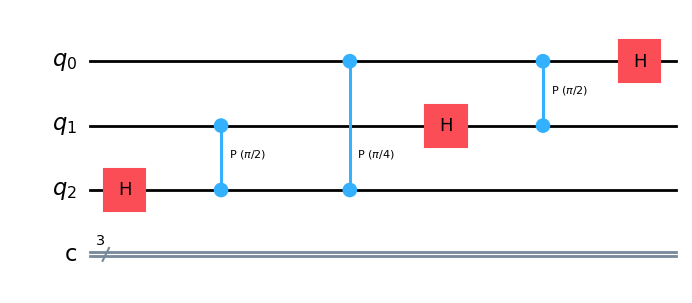

In [12]:
# Repeat the process for qubits 0 and 1
qc.h(1)
qc.cp(np.pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw('mpl')

Finally we must swap the qubits 0 and 2 to complete the QFT:

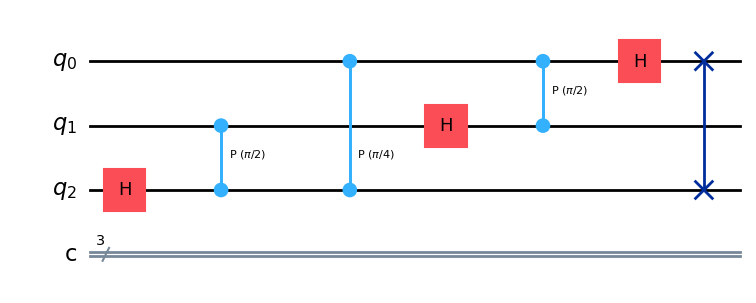

In [13]:
# Swap the qubits
qc.swap(0,2)

# Draw the resulting circuit
qc.draw('mpl')

### Exercise 3: General QFT Function

Create a general circuit for the QFT using basic Qiskit instructions.

It is easier to build a circuit that implements the QFT with the qubits upside down, then swap them afterwards;

Hint: start off by creating the function that rotates your qubits correctly. Start as you did with the 3 qubit example, by correctly rotating the most significant qubit (the qubit with the highest index). This is the first part of the QFT. Now you need to correctly rotate the second most significant qubit. Then you must deal with the third most significant, and so on. But why write more code? When we get to the end of our `qft_rotations()` function, we can use the same code to repeat the process on the next `n-1` qubits

In [14]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    ##############################
    # implement the function here

    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    ##############################
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    ##############################
    # implement the function here

    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

    ##############################
    return circuit

def qft(circuit, n):
    ##############################
    # implement the function here

    qft_rotations(circuit, n)
    swap_registers(circuit, n)

    ##############################
    return circuit

We now want to demonstrate this circuit works correctly. To do this we must first encode a number in the computational basis. We can see the number 5 in binary is `101`:

In [15]:
bin(5)

'0b101'

(The `0b` just reminds us this is a binary number).

### Exercise 4: Let's encode the number 5 into our qubits

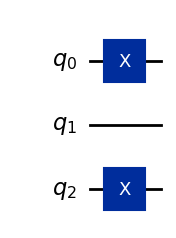

In [16]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw('mpl')

And let's check the qubit's states using the aer simulator:

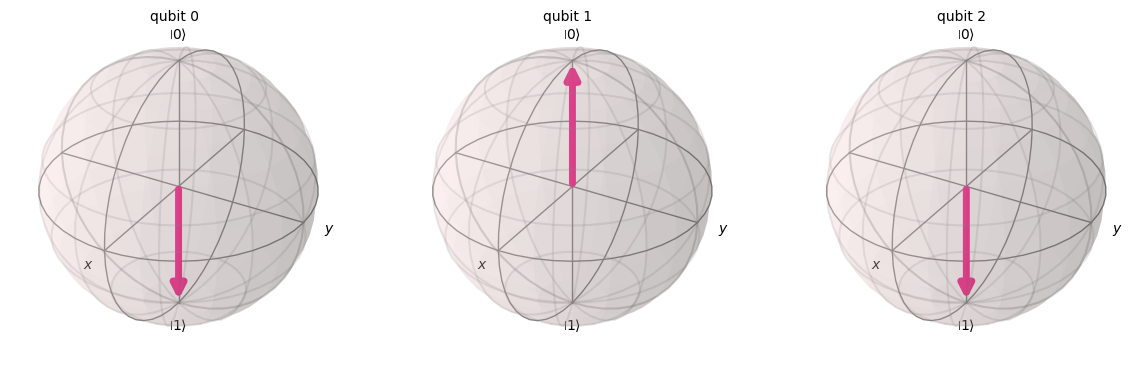

In [17]:
sim = Aer.get_backend("aer_simulator")

qc_copy = qc.copy()
qc_copy.save_statevector()

statevector = sim.run(qc_copy).result().get_statevector()
plot_bloch_multivector(statevector)

Finally, let's use our QFT function and view the final state of our qubits:

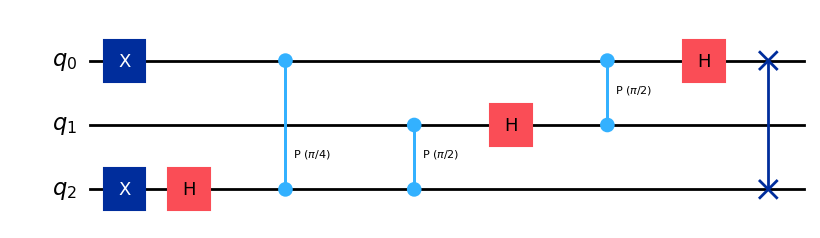

In [18]:
qft(qc,3)
qc.draw('mpl')

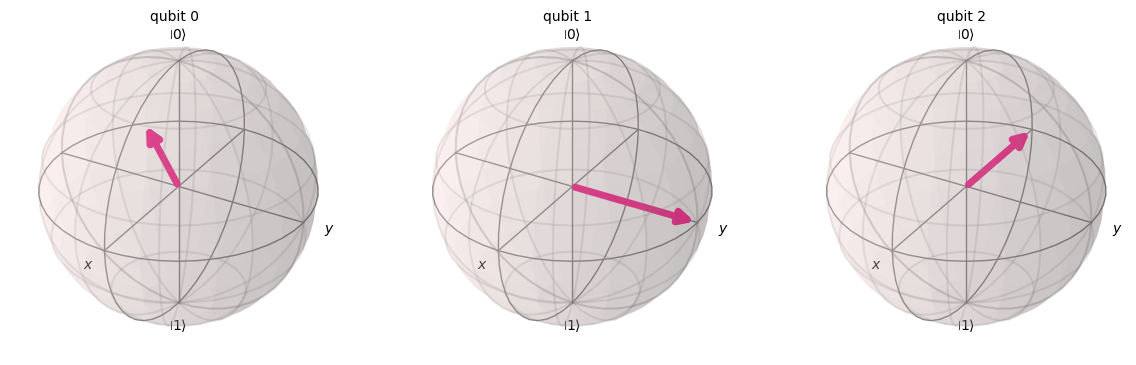

In [19]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

You can now see if your QFT function has worked correctly. Compared to the state $|\widetilde{0}\rangle = |{+}{+}{+}\rangle$, Qubit 0 should have been rotated by $\tfrac{5}{8}$ of a full turn, qubit 1 by $\tfrac{10}{8}$ full turns (equivalent to $\tfrac{1}{4}$ of a full turn), and qubit 2 by $\tfrac{20}{8}$ full turns (equivalent to $\tfrac{1}{2}$ of a full turn).

### Exercise 5: verify QFT without computing the statevector

If we tried running the circuit above on a real device, the results would be completely random, since all qubits are in equal superposition of $|0\rangle$ and $|1\rangle$. How can we demonstrate and investigate the QFT working on real hardware?

Hint: the starting point should be to put our qubits in the state represented by the image above (the state $|\widetilde{5}\rangle$)

In [20]:
# Create a circuit to verify the correctness of your QFT implementation without computing the StateVector

# The idea here is to use the inverse QFT to check if, starting from the transformed state, 
# we can get back to the original state
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates


Now let's put our qubits in the state $|\widetilde{5}\rangle$ and then apply our inverse QFT:

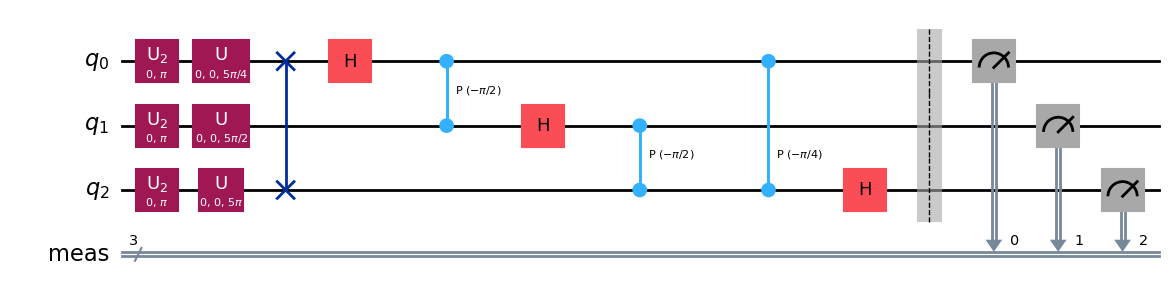

In [21]:
nqubits = 3
number = 5
iqft = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    iqft.h(qubit)
iqft.p(number*np.pi/4,0)
iqft.p(number*np.pi/2,1)
iqft.p(number*np.pi,2)

iqft = inverse_qft(iqft, nqubits)
iqft.measure_all()

iqft.draw('mpl')

Now test the resulting circuit on real quantum hardware

In [23]:
simulation = False
num_shots = 1024

if simulation:
    backend = AerSimulator()
    # You can use a fixed seed to get fixed results (error if run on quantum hardware).
    options = {"simulator": {"seed_simulator": 42}}
else:
    provider = IQMProvider(url="https://spark.quantum.linksfoundation.com/station", token=access_token)
    lagrange_backend = provider.get_backend()

    pm = generate_preset_pass_manager(optimization_level=1, backend=lagrange_backend)
    t_iqft = pm.run(iqft)

job = lagrange_backend.run(t_iqft, shots=num_shots)

station-control-client version '9.18.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.


In [24]:
# job = service.job('cw5dc68xa9wg0087w6n0')
result = job.result().get_counts()
print(result)
print()
# print({key:int(value*num_shots) for key,value in result.quasi_dists[0].binary_probabilities().items()})

{'101': 755, '000': 32, '001': 64, '111': 23, '100': 88, '011': 25, '010': 13, '110': 24}



## Quantum Phase Estimation

In [25]:
from math import pi, cos, sin
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager
from qiskit.primitives import BackendSampler
from qiskit_aer import Aer

### Recap 

Note: we will know use the greek letter $\theta$ to indicate the phase instead of $\phi$.

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator $U$, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. 

So, QPE estimates the phase of a unitary operator $U$. It estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, where $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. The circuit operates in the following steps:

i. **Setup**: $\vert\psi\rangle$ is in one set of qubit registers. An additional set of $n$ qubits form the counting register on which we will store the value $2^n\theta$: 



$$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$$

 

ii. **Superposition**: Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the counting register: 



$$ |\psi_1\rangle = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle$$



iii. **Controlled Unitary Operations**: We need to introduce the controlled unitary $CU$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operator with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means: 



$$U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$$



Applying all the $n$ controlled operations $CU^{2^j}$ with $0\leq j\leq n-1$, and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$:

\begin{aligned}
|\psi_{2}\rangle & =\frac {1}{2^{\frac {n}{2}}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle\\\\
& = \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \vert\psi\rangle
\end{aligned}
where $k$ denotes the integer representation of n-bit binary numbers. 

iv. **Inverse Fourier Transform**: Notice that the above expression is exactly the result of applying a quantum Fourier transform as we derived in past lessons. Recall that QFT maps an n-qubit input state $\vert x\rangle$ into an output as

$$
QFT\vert x \rangle = \frac{1}{2^\frac{n}{2}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
$$

Replacing $x$ by $2^n\theta$ in the above expression gives exactly the expression derived in step 2 above. Therefore, to recover the state $\vert2^n\theta\rangle$, apply an inverse Fourier transform on the auxiliary register. Doing so, we find

$$
\vert\psi_3\rangle = \frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle
$$ 

v. **Measurement**: 
The above expression peaks near $x = 2^n\theta$. For the case when $2^n\theta$ is an integer, measuring in the computational basis gives the phase in the auxiliary register with high probability: 



$$ |\psi_4\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$$



For the case when $2^n\theta$ is not an integer, it can be shown that the above expression still peaks near $x = 2^n\theta$ with probability better than $4/\pi^2 \approx 40\%$ [1].

### Exercise 0: example QPE

Create an example QPE circuit with one control qubit and a unitary operator represented by $R^{z}_\theta$

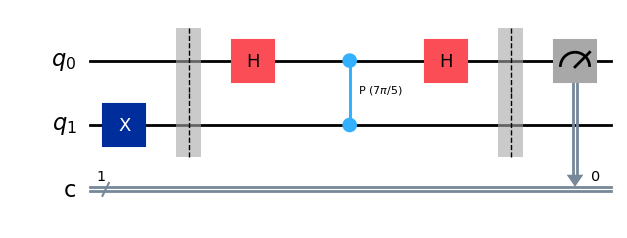

In [26]:
theta = 0.7  # Can be changed to any value between 0 and 1

qc = QuantumCircuit(2, 1)

##############################
# Prepare eigenvector, which is the |1> state
qc.x(1)
qc.barrier()

# Implement the estimation procedure
qc.h(0)
qc.cp(2 * pi * theta, 0, 1)
qc.h(0)
qc.barrier()

# Perform the final measurement
qc.measure(0, 0)

##############################

# Draw the circuit
qc.draw(output='mpl')

In [27]:
backend = Aer.get_backend('aer_simulator')

options = {"simulator": {"seed_simulator": 100}}
simulation_sampler = BackendSampler(backend, options=options)

pe_result = simulation_sampler.run([qc]).result()

print("Measured results:", 
      {key:value for key,value in pe_result.quasi_dists[0].binary_probabilities().items()})

print("\nExpected results:",{   # Calculate predicted results and check if they agree with slide 11
    0: cos(pi * theta) ** 2,
    1: sin(pi * theta) ** 2
},"\n")

Measured results: {'1': 0.65234375, '0': 0.34765625}

Expected results: {0: 0.34549150281252616, 1: 0.6545084971874737} 



/var/folders/74/wt_5qpj93q3376cvntqjvnm80000gn/T/ipykernel_15875/1144308859.py:4: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  simulation_sampler = BackendSampler(backend, options=options)


### Exercise 1: increase the precision

bring to two the amount of control qubits and rebuild the circuit accordingly

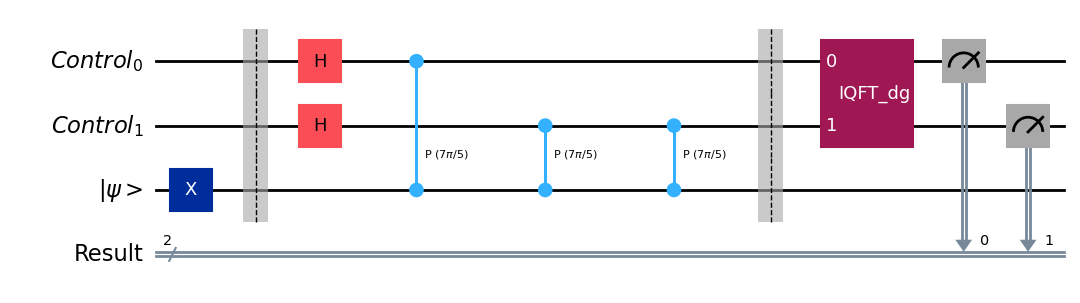

In [28]:
from qiskit.circuit.library import QFT

theta = 0.7
m = 2  # Number of control qubits

control_register = QuantumRegister(m, name="Control")
target_register = QuantumRegister(1, name="|ψ>")
output_register = ClassicalRegister(m, name="Result")
qc = QuantumCircuit(control_register, target_register, output_register)

##############################
# Prepare the eigenvector |ψ>
qc.x(target_register)
qc.barrier()

# Perform phase estimation
for index, qubit in enumerate(control_register):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2 * pi * theta, qubit, target_register)
qc.barrier()

##############################
# Do inverse quantum Fourier transform
# You can use the QFT class and the circuit.compose() method
inverse_QFT = QFT(m, inverse=True)
qc.compose(
    inverse_QFT,
    inplace=True
)

##############################
# Measure everything
qc.measure(control_register, output_register)

##############################

# Draw the circuit
display(qc.draw("mpl"))

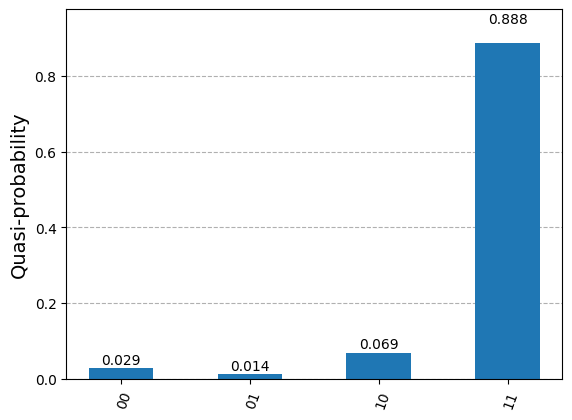

In [29]:
from qiskit.visualization import plot_histogram

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
transpiled_qc = pm.run(qc)

result = simulation_sampler.run([transpiled_qc]).result().quasi_dists[0].binary_probabilities().items()
display(plot_histogram(dict(result)))

### Are your results consistent with the image below?

<img src='https://drive.google.com/uc?id=1rciiD6RBd2mKpUGZwUjldC37yihxw06u'>

### Exercise 2: T-gate <a id='example_t_gate'></a>

Let’s take a gate we know well, the $T$-gate, and use Quantum Phase Estimation to estimate its phase. You will remember that the $T$-gate adds a phase of $e^\frac{i\pi}{4}$ to the state $|1\rangle$:

$$ T|1\rangle = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle $$

Since QPE will give us $\theta$ where:



$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$



We expect to find:



$$\theta = \frac{1}{8}$$



Use three qubits and obtain an _exact_ result (not an estimation!)

### Creating the Circuit <a id='creating_the_circuit'></a>


Now, set up the quantum circuit. We will use four qubits -- qubits 0 to 2 as counting qubits, and qubit 3 as the eigenstate of the unitary operator ($T$). 

First, initialize $\vert\psi\rangle$:

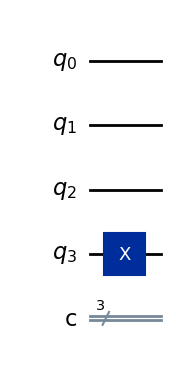

In [30]:
qpe = QuantumCircuit(4, 3)
##############################
# Prepare the eigenvector |ψ>
qpe.x(3)

##############################
qpe.draw('mpl')

Next, we apply Hadamard gates to the counting (control) qubits:

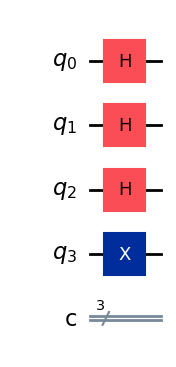

In [31]:
##############################
# Perform the initial set of hadamard gates
for qubit in range(3):
    qpe.h(qubit)

##############################
qpe.draw('mpl')

Next we perform the controlled unitary operations. 

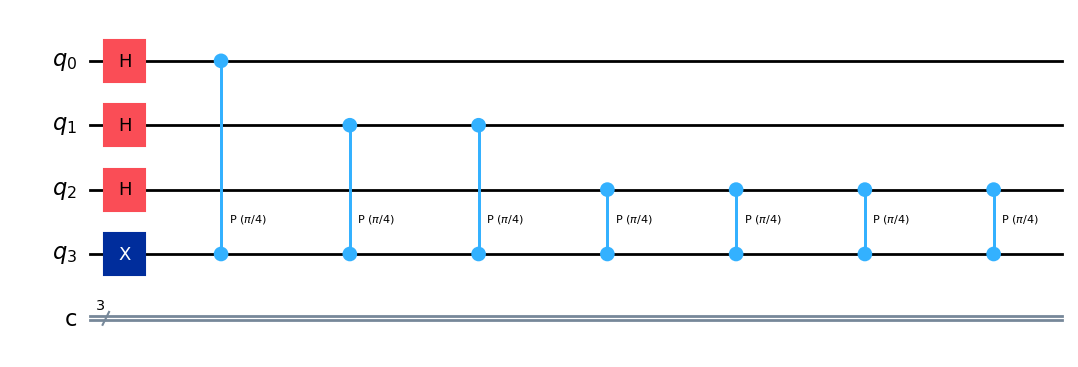

In [32]:

# Perform controlled unitary operations
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(pi/4, counting_qubit, 3); # This is CU
    repetitions *= 2

qpe.draw('mpl')

Apply the inverse quantum Fourier transformation to convert the state of the counting register. Implement the code ore use the QFT class (recommended):

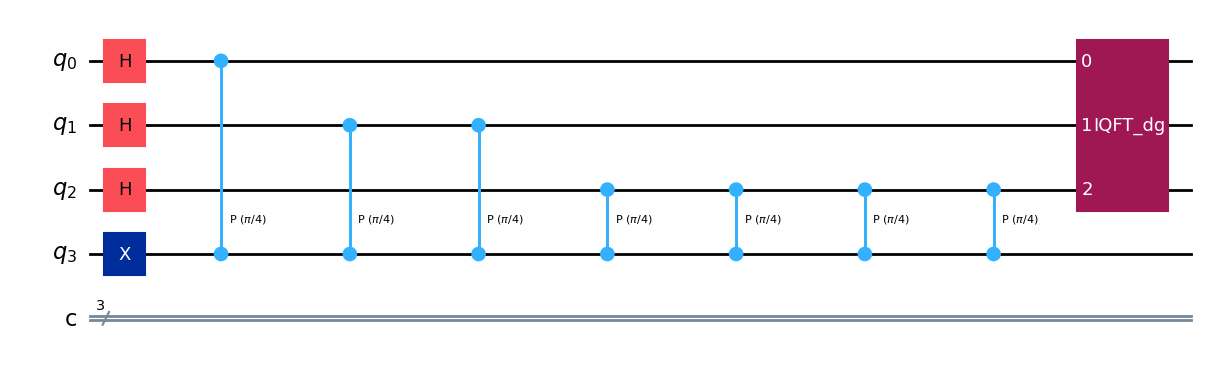

In [33]:
##############################
# Perform the inverse quantum Fourier transform
i_QFT = QFT(3, inverse=True)
qpe.compose(
    i_QFT,
    inplace=True
)

##############################
qpe.draw('mpl')

Then measure the counting register:

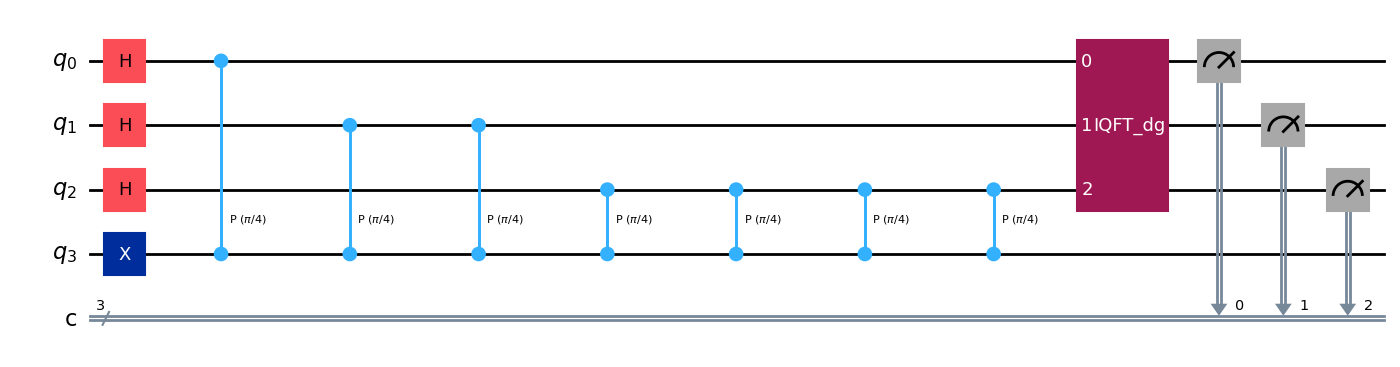

In [34]:

# Measure
for n in range(3):
    qpe.measure(n,n)


qpe.draw('mpl')

### Check the Results <a id='results'></a>

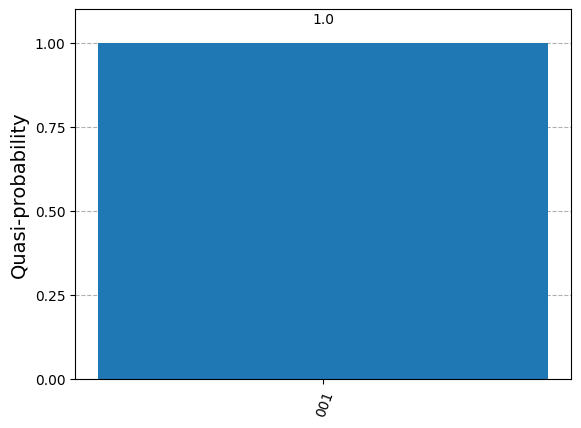

In [35]:
# Let's see the results!
t_qpe = pm.run(qpe)

results = simulation_sampler.run([t_qpe]).result().quasi_dists[0].binary_probabilities().items()
answer = dict(results)

plot_histogram(answer)

You should get only one result (one bitstring) with certainty, which translates to a specific decimal. You now need to divide your result by $2^n$ and verify that you get $\theta$

In [36]:
theta = int('001',2) / 2**3 
print(theta)

0.125


### Getting More Precision <a id='getting_more_precision'></a>

Instead of a $T$-gate, let’s use a gate with $\theta = \frac{1}{3}$. Let's set up the circuit as with the last example:

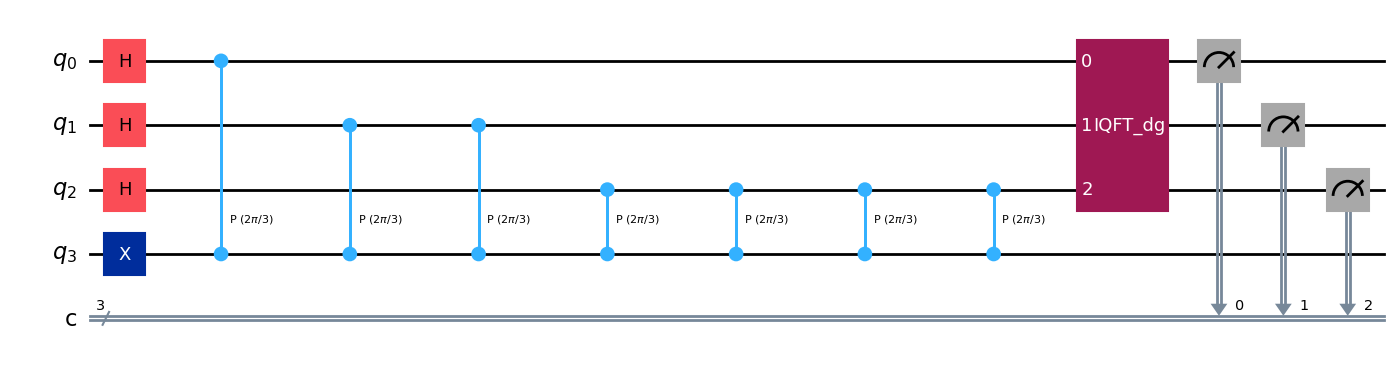

In [37]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)


# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
i_QFT = QFT(3, inverse=True)
qpe2.compose(
    i_QFT,
    inplace=True
)

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)


# Draw the circuit

qpe2.draw('mpl')

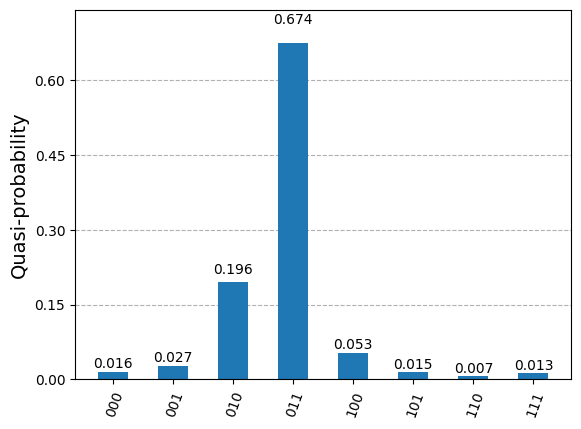

In [38]:
# Let's see the results!
t_qpe2 = pm.run(qpe2)

##############################
# run the circuit using the simulation_sampler defined earlier
results = simulation_sampler.run([t_qpe2]).result().quasi_dists[0].binary_probabilities().items()
answer = dict(results)

# use plot_histogram() to display the results of get_counts()
plot_histogram(answer)

##############################

Complete the following: we are expecting the result $\theta = 0.3333\dots$, and we see our most likely results are 010(bin) = 2(dec) and 011(bin) = 3(dec). These two results would tell us that $\theta =$ 0.25 (off by 25%) and $\theta =$ 0.375 (off by 13%) respectively. The true value of $\theta$ lies between the values we can get from our counting bits, and this gives us uncertainty and imprecision.

### The Solution 
To get more precision we simply add more counting qubits. We are going to add two more counting qubits:

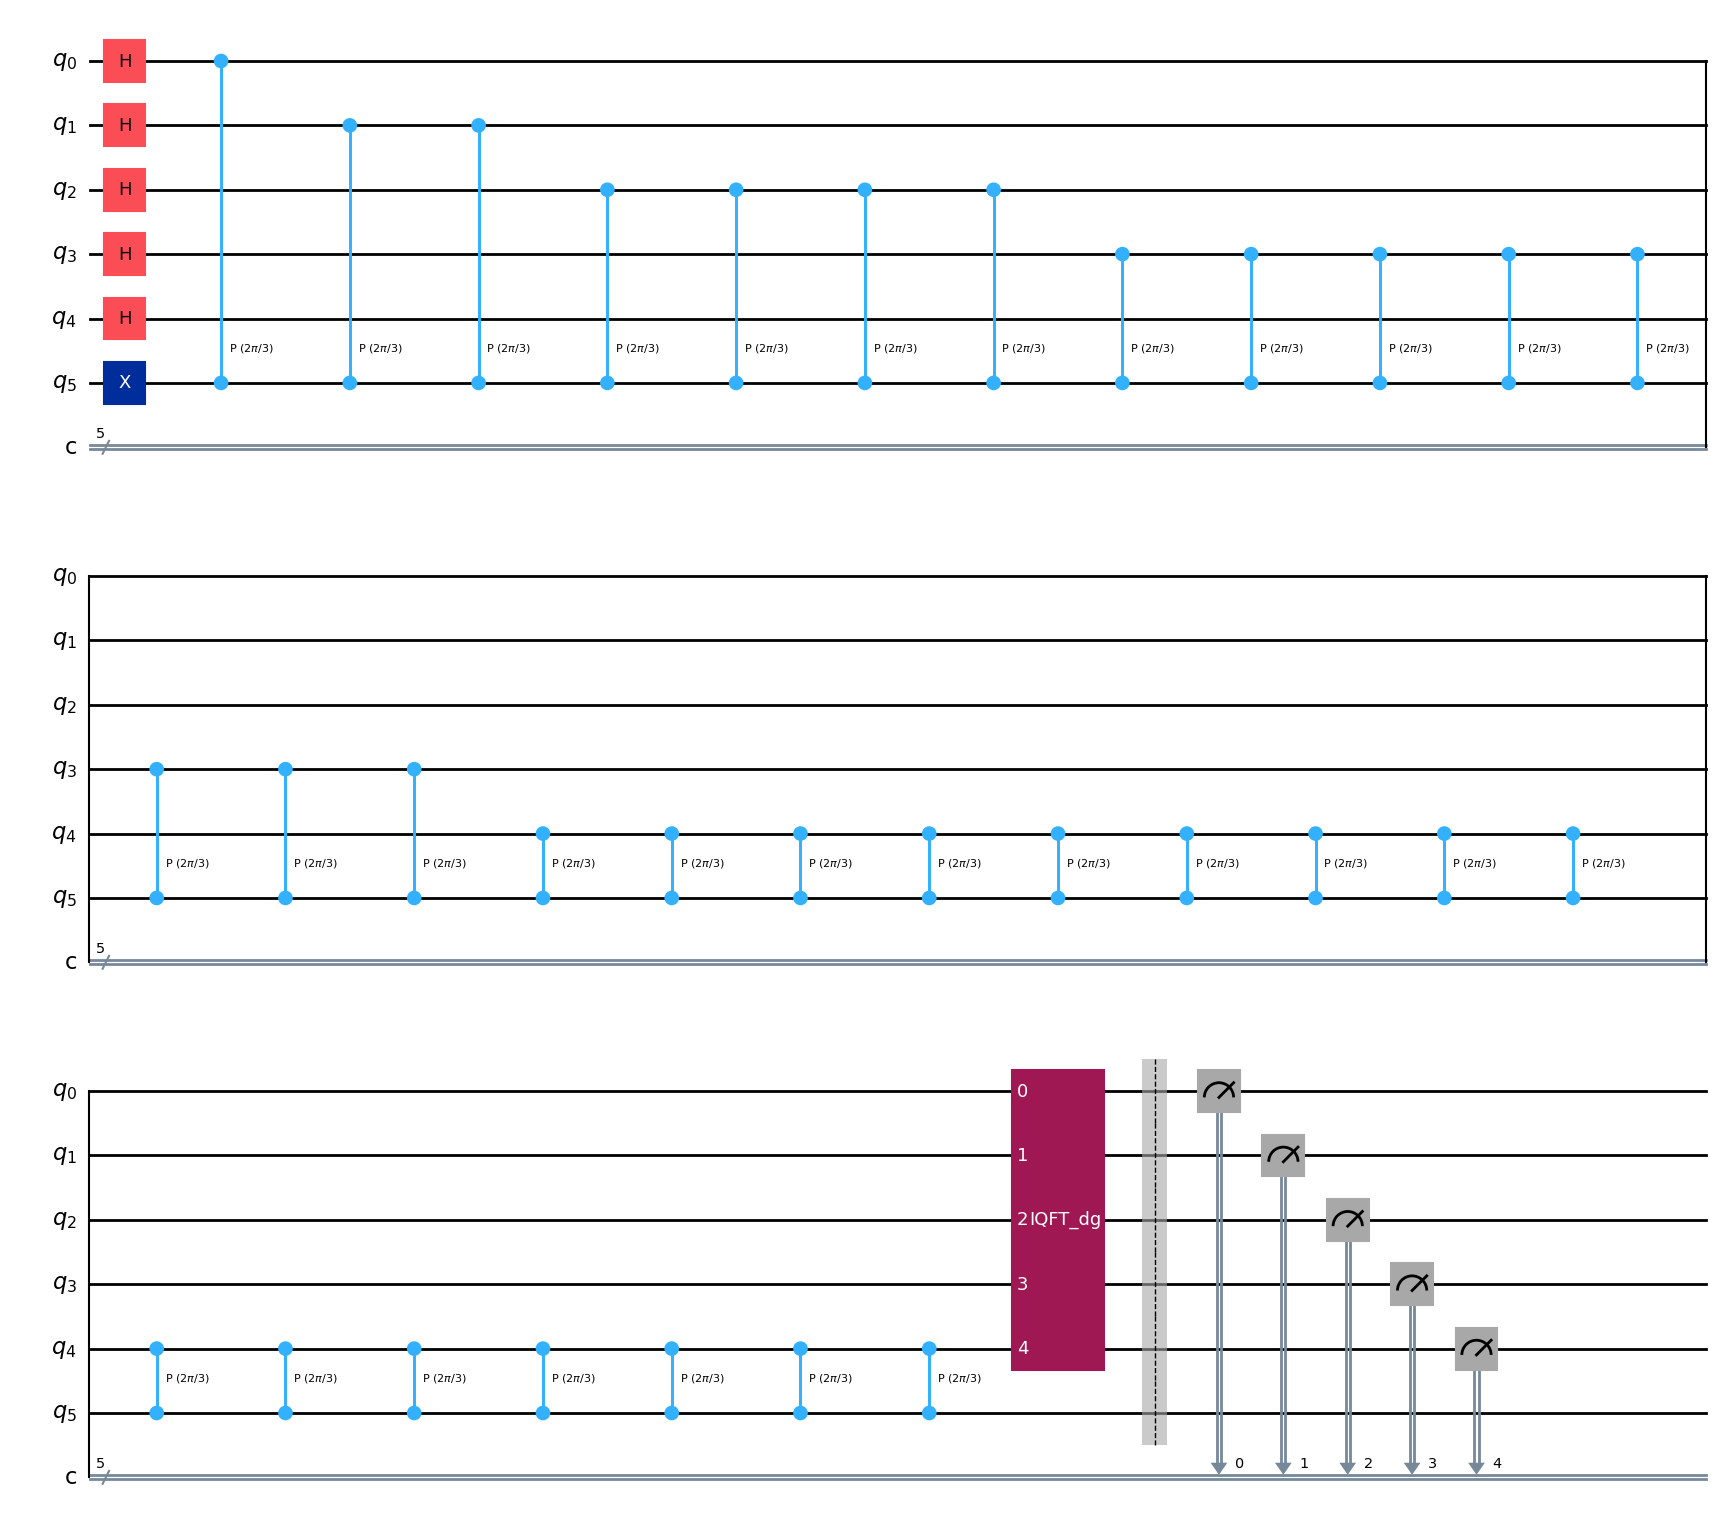

In [39]:
# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

##############################
# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
i_QFT = QFT(5, inverse=True)
qpe3.compose(
    i_QFT,
    inplace=True
)

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)

##############################

# Draw the circuit
qpe3.draw('mpl')

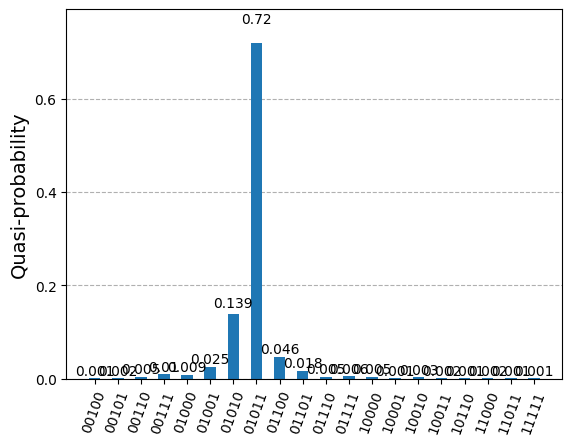

In [40]:
# Let's see the results!
t_qpe3 = pm.run(qpe3)

##############################
# run the circuit using the simulation_sampler defined earlier
results = simulation_sampler.run([t_qpe3]).result().quasi_dists[0].binary_probabilities().items()
answer = dict(results)

# use plot_histogram() to display the results of get_counts()
plot_histogram(answer)

##############################

The two most likely measurements are now 01011 (decimal 11) and 01010 (decimal 10). Measuring these results would tell us $\theta$ is:

$$\theta = \frac{11}{2^5} = 0.344,\;\text{  or  }\;\; \theta = \frac{10}{2^5} = 0.313$$

These two results differ from $\frac{1}{3}$ by 3% and 6% respectively. A much better precision!

### Exercise 3: Experiment with Real Devices <a id='real_devices'></a>


We can run the circuit in exercise 2 on a real device, let's remind ourselves of the circuit:

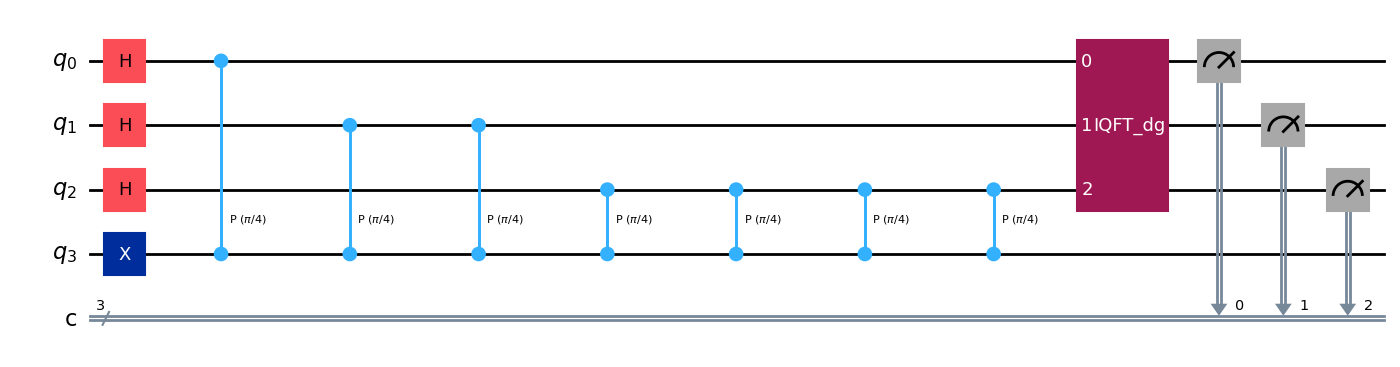

In [41]:
qpe.draw('mpl')

In [42]:
##############################
# Transpile and then run the circuit on the lagrange backend
pm = generate_preset_pass_manager(optimization_level=1, backend=lagrange_backend)
transpiled_qpe = pm.run(qpe)

# Run with 2048 shots
shots = 2048
job = lagrange_backend.run(transpiled_qpe, shots=shots)

##############################


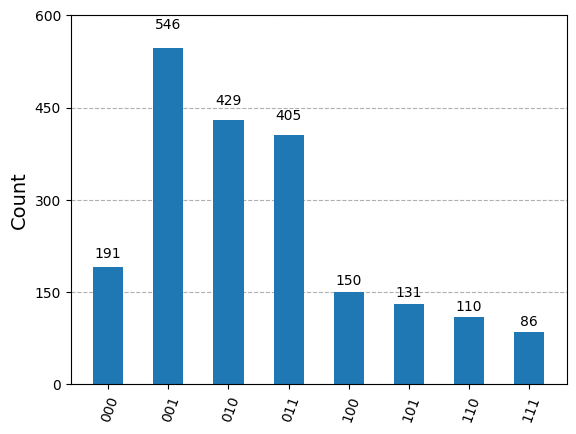

In [43]:
##############################
# get the results from the computation and plot the histogram
results = job.result()
answer = results.get_counts()

plot_histogram(answer)


##############################


We can hopefully see that the most likely result is `001` which is the result we would expect from the simulator. Unlike the simulator, there is a probability of measuring something other than `001`, this is due to noise and gate errors in the quantum computer.

### Exercise 4: a general QPE construction
Use the ```PhaseEstimation``` class to create a QPE circuit. It needs a primitive sampler!

In [44]:
from qiskit_algorithms import PhaseEstimation
from qiskit.circuit.library import TGate


unitary = QuantumCircuit(1, name='U')
unitary.t(0)

state_preparation = QuantumCircuit(1, name='StatePrep')
state_preparation.x(0)

num_control_qubits = 3

##################


qpe_circuit = PhaseEstimation(num_evaluation_qubits=num_control_qubits,
                                  sampler=simulation_sampler)

##################

result = qpe_circuit.estimate(unitary=unitary, state_preparation=state_preparation)

print("Estimated phase:", result)


Estimated phase: {   'circuit_result': SamplerResult(quasi_dists=[{4: 1.0}],
                                    metadata=[{'shots': 1024}]),
    'phase': 0.125,
    'phases': {'001': 1.0}}


## Shor’s Algorithm

In [55]:
from qiskit import *

from qiskit_aer import Aer

from fractions import Fraction
import matplotlib.pyplot as plt

### Recap

Shor’s algorithm is famous for factoring integers in polynomial time. Since the best-known classical algorithm requires greater-than-polynomial time to factor the product of two primes, the widely used cryptographic protocol, RSA, relies on factoring being impossible for large enough integers.

In this lab we will focus on implementing Shor’s algorithm, which actually solves the problem of _period finding_. Since a factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too. For now its enough to show that if we can compute the period of $a^x\bmod N$ efficiently, then we can also efficiently factor.

Let’s look at the periodic function:

$$ f(x) = a^x \bmod{N}$$

<details>
    <summary>Reminder: Modulo &amp; Modular Arithmetic (Click here to expand)</summary>

The modulo operation (abbreviated to 'mod') simply means to find the remainder when dividing one number by another. For example:

$$ 17 \bmod 5 = 2 $$

Since $17 \div 5 = 3$ with remainder $2$. (i.e. $17 = (3\times 5) + 2$). In Python, the modulo operation is denoted through the <code>%</code> symbol.

This behaviour is used in <a href="https://en.wikipedia.org/wiki/Modular_arithmetic">modular arithmetic</a>, where numbers 'wrap round' after reaching a certain value (the modulus). Using modular arithmetic, we could write:

$$ 17 = 2 \pmod 5$$

Note that here the $\pmod 5$ applies to the entire equation (since it's in parenthesis), unlike the equation above where it only applied to the left-hand side of the equation.
</details>

where $a$ and $N$ are positive integers, $a$ is less than $N$, and they have no common factors. The period, or order ($r$), is the smallest (non-zero) integer such that:

\begin{equation} a^r \bmod N = 1 \end{equation}

We can see an example of this function plotted on the graph below. Note that the lines between points are to help see the periodicity and do not represent the intermediate values between the x-markers.

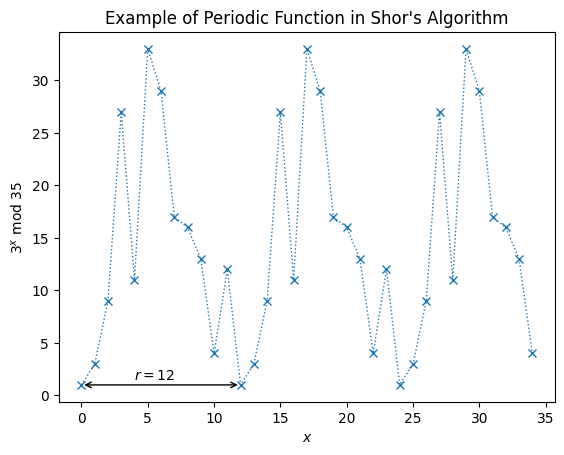

In [ ]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")

try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

Shor’s solution is to use *quantum phase estimation* on the unitary operator:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

To see how this is helpful, let’s work out what an eigenstate of $U$ might look like. If we started in the state $|1\rangle$, we can see that each successive application of $U$ will multiply the state of our register by $a \pmod N$, and after $r$ applications we will arrive at the state $|1\rangle$ again. For example with $a = 3$ and $N = 35$:

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}$$

Now let's think about the eigenvectors and eigenvalues of the operation $U$.

There are $N$ eigenvalues of $U$, possibly including the same eigenvalue repeated multiple times, and in general there's some freedom in selecting corresponding eigenvectors - but we won't need to worry about all of the possibilities. Let's start simple and identify just one eigenvector of $U$.

$$
\left|u_0\right\rangle=\frac{|1\rangle+|a\rangle+\cdots+\left|a^{r-1}\right\rangle}{\sqrt{r}}
$$


In fact, a superposition of the states in this cycle would be an eigenstate of $U$. The eigenvalue associated with this eigenvector is 1 because it isn't changed when we multiply by $a$.

$$
U\left|u_0\right\rangle=\frac{|a\rangle+\cdots+\left|a^{r-1}\right\rangle+\left|a^r\right\rangle}{\sqrt{r}}=\frac{|a\rangle+\cdots+\left|a^{r-1}\right\rangle+|1\rangle}{\sqrt{r}}=\left|u_0\right\rangle
$$


This happens because $a^r=1$, so each standard basis state $\left|a^k\right\rangle$ gets shifted to $\left|a^{k+1}\right\rangle$ for $k \leq r-$ 1 , and $\left|a^{r-1}\right\rangle$ gets shifted back to $|1\rangle$.

<details>
    <summary>Click to Expand: Example with a = 3 and N = 35</summary>

$$\begin{aligned}
|u_0\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}$$
</details>

Again, this eigenstate has an eigenvalue of 1, which isn’t very interesting. A more interesting eigenstate could be one in which the phase is different for each of these computational basis states. Specifically, let’s look at the case in which the phase of the $k^\text{th}$ state is proportional to $k$:

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle 
\end{aligned}
$$

Alternatively, we can write this vector as follows.

$$
\left|u_1\right\rangle=\frac{|1\rangle+\omega_r^{-1}|a\rangle+\cdots+\omega_r^{-(r-1)}\left|a^{r-1}\right\rangle}{\sqrt{r}}
$$

$$
\left|u_1\right\rangle=\frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} \omega_r^{-k}\left|a^k\bmod N\right\rangle
$$


Here we see the primitive $r^{th}$ root of unity $\omega_r=e^{2 \pi i / r}$ showing up naturally, due to the underlying structure of multiplication by a modulo $N$. This time the corresponding eigenvalue is $\omega_r$. 


<details>
    <summary>Click to Expand: Example with a = 3 and N = 35</summary>

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{\tfrac{-2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle + e^{-\tfrac{6\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

(We can see $r = 12$ appears in the denominator of the phase.)
</details>

This is a particularly interesting eigenvalue as it contains $r$. In fact, $r$ has to be included to make sure the phase differences between the $r$ computational basis states are equal. This is not the only eigenstate with this behaviour; to generalise this further, we can multiply an integer, $j$, to this phase difference, which will show up in our eigenvalue:

$$\begin{aligned}
|u_j\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i j k}{r}}|a^k \bmod N\rangle}\\[10pt]
\end{aligned}$$

So, $|u_j\rangle$ is an eigenvector of $U$ whose corresponding eigenvalue is $\omega_r^{j} = e^{\tfrac{2\pi i j}{r}}$. 

$$\begin{aligned}
U|u_j\rangle &= e^{\tfrac{2\pi i j}{r}}|u_j\rangle 
\end{aligned}
$$

<details>
    <summary>Click to Expand: Example with a = 3 and N = 35</summary>

$$\begin{aligned}
|u_j\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i j}{12}}|3\rangle + e^{-\tfrac{4\pi i j}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i j}{12}}|4\rangle + e^{-\tfrac{22\pi i j}{12}}|12\rangle) \\[10pt]
U|u_j\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i j}{12}}|9\rangle + e^{-\tfrac{4\pi i j}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i j}{12}}|12\rangle + e^{-\tfrac{22\pi i j}{12}}|1\rangle) \\[10pt]
U|u_j\rangle &= e^{\tfrac{2\pi i j}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{-\tfrac{2\pi i j}{12}}|3\rangle + e^{-\tfrac{4\pi i j}{12}}|9\rangle + e^{-\tfrac{6\pi i j}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i j}{12}}|12\rangle + e^{-\tfrac{24\pi i j}{12}}|1\rangle) \\[10pt]
U|u_j\rangle &= e^{\tfrac{2\pi i j}{12}}|u_j\rangle
\end{aligned}$$

</details>

We now have a unique eigenstate for each integer value of $j$ where $0 \leq j \leq r-1.$ Very conveniently, if we sum up all these eigenstates, the different phases cancel out all computational basis states except $|1\rangle$:

$$ \tfrac{1}{\sqrt{r}}\sum_{j=0}^{r-1} |u_j\rangle = |1\rangle$$

<details>
    <summary>Click to Expand: Example with a = 7 and N = 15</summary>

For this, we will look at a smaller example where $a = 7$ and $N=15$. In this case $r=4$:

$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$

</details>

Since the computational basis state $|1\rangle$ is a superposition of these eigenstates, which means if we do QPE on $U$ using the state $|1\rangle$, we will measure a phase:

$$\phi = \frac{j}{r}$$

Where $j$ is a random integer between $0$ and $r-1$. We finally use the [continued fractions](https://en.wikipedia.org/wiki/Continued_fraction) algorithm on $\phi$ to find $r$. The circuit diagram looks like this (note that this diagram uses Qiskit's qubit ordering convention):

![image.png](https://raw.githubusercontent.com/Qiskit/textbook/aebdd2bc86ddb7a79dd8441d52c839d312ffafbb/notebooks/ch-algorithms/images/shor_circuit_1.svg)

### example unitary operator for $N=15$

In this example we will solve the period finding problem for $a=7$ and $N=15$. Below you find the circuits for $U$ where:

$$U|y\rangle = |ay\bmod 15\rangle $$

To create $U^x$, we will simply repeat the circuit $x$ times. Later we will discuss a general method for creating these circuits efficiently. The function `amod15` returns the U gate for `a`, repeated `power` times.

In [46]:
def amod15(a, power):
    """Multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    return U

### Exercise 1:

Confirm if the unitary operator $U$ works properly by creating a quantum circuit with $m$ qubits.  Prepare the input state representing any integer between 0 and 15 (exclusive) such as $|1\rangle (=|0001\rangle), |5\rangle (=|0101\rangle), |13\rangle (=|1101\rangle)$ etc, and apply $U$ gate on it. Check if the circuit produces the expected outcomes for several inputs.  The outcome state for the input $|1\rangle$ should be $|7\rangle (=|0111>$) and $|1\rangle$ for the input $|13\rangle$, for example. 

In [48]:
aer_sim = Aer.get_backend('aer_simulator')
pm_sim = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

In [50]:
# Create a quantum circuit with 4 qubits (for the input state)
qc = QuantumCircuit(4)

# Prepare the input state |1> (which is |0001> in binary)
qc.x(0)

# Apply the unitary operator U
qc.append(amod15(7, 1), [0, 1, 2, 3])

# Simulate the circuit
qc.measure_all()

t_qc = pm_sim.run(qc)

result = aer_sim.run(t_qc).result()
counts = result.get_counts()

# Print the results
print("Input state |1> (|0001>) should result in |7> (|0111>):")
print(counts)

Input state |1> (|0001>) should result in |7> (|0111>):
{'0111': 1024}


## Exercise 2: Shor for $a=7$ and $N=15$
Use QPE with the controlled operator obtained by the function defined above, in order to perform Shor's Algorithm

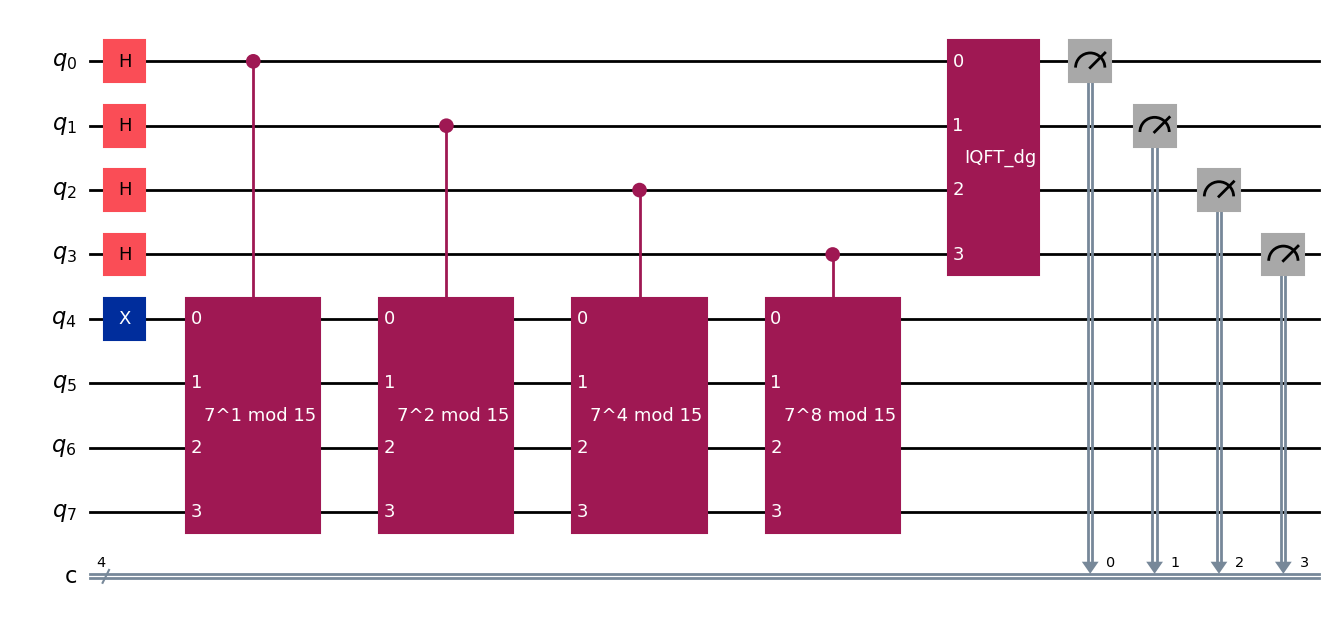

In [51]:
# Specify variables
N = 15
N_COUNT = 4  # number of counting qubits
a = 7

# We create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

##############################
# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

##############################

# Next, we do controlled-U operations (you can use the .control() method)
for q in range(N_COUNT):
    qc.append(amod15(a, 2**q).control(),
             [q] + [i+N_COUNT for i in range(4)])

##############################
# Do inverse-QFT

qft_dagger = QFT(N_COUNT, inverse=True)
qc.compose(qft_dagger, inplace=True)

##############################

# Measure circuit and draw it
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw("mpl", fold=-1)  # -1 means 'do not fold'

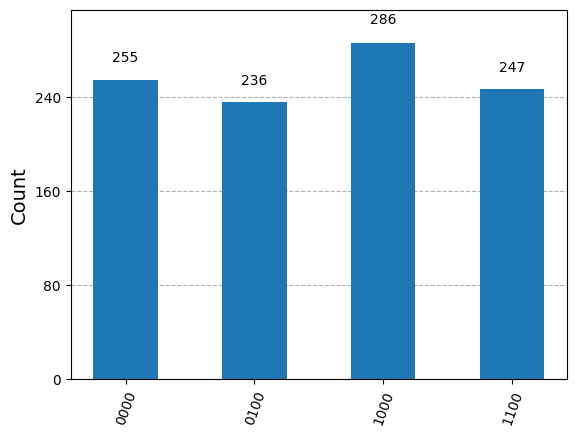

In [52]:
##############################
# Simulate the circuit and get the counts
t_qc = pm_sim.run(qc)

result = aer_sim.run(t_qc).result()
counts = result.get_counts()

##############################
plot_histogram(counts)

In [53]:
rows, measured_phases = [], []
print("\tRegister Output\t\tPhase")
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
    print(rows[-1])

	Register Output		Phase
['0100(bin) =   4(dec)', '4/16 = 0.25']
['1100(bin) =  12(dec)', '12/16 = 0.75']
['0000(bin) =   0(dec)', '0/16 = 0.00']
['1000(bin) =   8(dec)', '8/16 = 0.50']


We can now use the continued fractions algorithm to attempt to find $s$ and $r$. Python has this functionality built in: We can use the `fractions` module to turn a float into a `Fraction` object, for example:

In [56]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Because this gives fractions that return the result exactly (in this case, `0.6660000...`), this can give gnarly results like the one above. We can use the `.limit_denominator()` method to get the fraction that most closely resembles our float, with denominator below a certain value:

In [57]:
# Get fraction that most closely resembles our float with denominator < 15
rows = []
print("Phase\tFract\tGuess for r")
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
    for el in rows[-1]:
        print(el, end="\t")
    print()

Phase	Fract	Guess for r
0.25	1/4	4	
0.75	3/4	4	
0.0	0/1	1	
0.5	1/2	2	


We can see that two of the measured eigenvalues provided us with the correct result: $r=4$, and we can see that Shor’s algorithm has a chance of failing. These bad results are because $s = 0$, or because $s$ and $r$ are not coprime and instead of $r$ we are given a factor of $r$. The easiest solution to this is to simply repeat the experiment until we get a satisfying result for $r$.

### Quick Additional Exercise (1.5):

- Change the circuit above for values of $a = 2, 8, 11$ and $13$. What results do you get and why?

## Exercise 3: Factoring from Period Finding

Not all factoring problems are difficult; we can spot an even number instantly and know that one of its factors is 2. In fact, there are [specific criteria](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.186-4.pdf#%5B%7B%22num%22%3A127%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C70%2C223%2C0%5D) for choosing numbers that are difficult to factor, but the basic idea is to choose the product of two large prime numbers.

A general factoring algorithm will first check to see if there is a shortcut to factoring the integer (is the number even? Is the number of the form $N = a^b$?), before using Shor’s period finding for the worst-case scenario. Since we aim to focus on the quantum part of the algorithm, we will jump straight to the case in which N is the product of two primes.

### Example: Factoring 15

To see an example of factoring on a small number of qubits, we will factor 15, which we all know is the product of the not-so-large prime numbers 3 and 5.

The first step is to choose a random number, $a$, between $1$ and $N-1$:

In [58]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = np.random.randint(2, 15)
print(a)

# Next we quickly check it isn't already a non-trivial factor of $N$:
from math import gcd # greatest common divisor
gcd(a, N)

7


1

Great. Next, do Shor's order finding algorithm for `a = 7` and `N = 15`. Remember that the phase we measure will be $s/r$ where:

$$ a^r \bmod N = 1 $$

and $s$ is a random integer between 0 and $r-1$.

In [59]:
# Create a function that performs the quantum phase estimation for a given 'a' (N=15)
def qpe_amod15(a, num_counting_qubits):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
        num_counting_qubits (int): The number of qubits in the counting register
    Returns:
        QuantumCircuit: Circuit to execute to get estimate of the phase
    """
    ##############################

    N_COUNT = num_counting_qubits
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(amod15(a, 2**q).control(),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.compose(QFT(N_COUNT, inverse=True), inplace=True) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))

    ##############################
    return qc

In [60]:
# Create a function that simulate the results and compute the phase
def simulate_and_compute_phase(qc):
    """Performs noiseless simulation of a circuit.
    Args:
        qc (QuantumCircuit): This is the circuit we want to simulate (just one shot)
    Returns:
        phase (float): Estimation for the phase
    """
    ##############################
    
    t_qc = pm_sim.run(qc)

    result = aer_sim.run(t_qc, shots=1).result()
    counts = result.get_counts()
    readings = list(counts.keys())
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")

    ##############################
    return phase

From this phase, we can easily find a guess for $r$:

In [67]:
phase = simulate_and_compute_phase(qpe_amod15(a, N_COUNT))
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

Register Reading: 0100
Corresponding Phase: 0.25
4


Now we have $r$, we might be able to use this to find a factor of $N$. Since:

$$a^r \bmod N = 1 $$

then:

$$(a^r - 1) \bmod N = 0 $$

which means $N$ must divide $a^r-1$. And if $r$ is also even, then we can write:

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

(if $r$ is not even, we cannot go further and must try again with a different value for $a$). There is then a high probability that the greatest common divisor of $N$ and either $a^{r/2}-1$, or $a^{r/2}+1$ is a proper factor of $N$:

In [68]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


### Last step: Iterate
In the cell below repeat the algorithm until at least one factor of 15 is found. You should try re-running the cell a few times to check how it behaves.

In [72]:
a = 7
factor_found = False
attempt = 0

while not factor_found:
    attempt += 1
    print(f"\nATTEMPT {attempt}:")
    qc = qpe_amod15(a, N_COUNT) # Phase = s/r
    phase = simulate_and_compute_phase(qc)
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"** Non-trivial factor found: {guess} **")
                factor_found = True


ATTEMPT 1:
Register Reading: 0000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 2:
Register Reading: 0000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 3:
Register Reading: 1000
Corresponding Phase: 0.5
Result: r = 2
Guessed Factors: 3 and 1
** Non-trivial factor found: 3 **


Here there is a possible output of the cell above:

ATTEMPT 1:  
Register Reading: 10000000  
Corresponding Phase: 0.5  
Result: r = 2  
Guessed Factors: 1 and 1  

ATTEMPT 2:  
Register Reading: 10000000  
Corresponding Phase: 0.5  
Result: r = 2  
Guessed Factors: 1 and 1  

ATTEMPT 3:  
Register Reading: 11000000  
Corresponding Phase: 0.75  
Result: r = 4  
Guessed Factors: 1 and 5  
** Non-trivial factor found: 5 **  

## Exercise 5: Noise Simulation

**Goal**

Perform the noise simulaton of our quantum order-finding circuits. 

I suggest you to first test with 6 or less counting qubits for the QPE part

In [ ]:
%pip install qiskit-ibm-runtime

In [75]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeTorino
 
qc = qpe_amod15(a, num_counting_qubits=4)

# Run the sampler job locally using FakeTorino as a backend
fake_torino = FakeTorino()
##############################
# Transpile the circuit
pm = generate_preset_pass_manager(backend=fake_torino, optimization_level=1)
transpiled_qc = pm.run(qc)

# Use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}

##############################
sampler = Sampler(mode=fake_torino, options=options)
 
result = sampler.run([transpiled_qc]).result()[0]

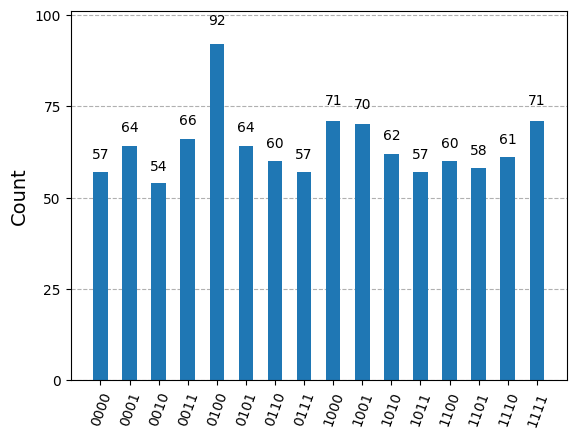

In [76]:
##############################
#Plot the counts using plot_histogram()

counts = result.data.c.get_counts()
plot_histogram(counts)
##############################

From the plot above, do you think the circuit would produce meaningful results if run on a QPU? 

Answer: no